In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
# Load data
data_path = "/content/drive/MyDrive/NLP/spa.txt"
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Reverse order: English target, Spanish input
    pairs = [[s.strip() for s in line.split('\t')[:2]] for line in lines]  # Assumes tab-separated data
    # Reverse each pair: Spanish -> English for training
    reversed_pairs = [[pair[1], pair[0]] for pair in pairs]  # Spanish as input and English as output
    return reversed_pairs

# Load sentence pairs
pairs = load_data(data_path)
np.random.shuffle(pairs)

In [3]:
len(pairs)

141543

In [4]:
pairs[:5]

[['Por favor vuelve algún día que no estés ocupado.',
  "Please come around someday when you aren't busy."],
 ['Me gusta teñirme el pelo.', 'I like to dye my hair.'],
 ['Tomás me estuvo mensajeando.', 'Tom has been texting me.'],
 ['Todos estamos un poco locos.', "We're all a bit crazy."],
 ['No me gusta ver películas subtituladas.',
  "I don't like watching subtitled movies."]]

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add start and end tokens to target sentences
def preprocess_data(pairs, num_samples=None):
    input_texts, target_texts = [], []
    for input_text, target_text in pairs[:num_samples]:
        # Add spaces around \t and \n to ensure they are treated as separate tokens
        target_text = " \t " + target_text.strip() + " \n "
        input_texts.append(input_text.strip())  # Strip whitespace
        target_texts.append(target_text)
    return input_texts, target_texts


input_texts, target_texts = preprocess_data(pairs,num_samples=110000)

# Tokenize at the character level
#tokenizer = Tokenizer(char_level=True)

# Tokenize
tokenizer_es = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
tokenizer_es.fit_on_texts(input_texts) # Fit on Spanish input text

tokenizer_en = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
tokenizer_en.fit_on_texts(target_texts) # Fit on English target text

# Convert to sequences
input_sequences = tokenizer_es.texts_to_sequences(input_texts) # Tokenize Spanish (input)
target_sequences = tokenizer_en.texts_to_sequences(target_texts) # Tokenize English (target)

# Padding
max_encoder_seq_length = max(len(seq) for seq in input_sequences) # Max length of Spanish sentences
max_decoder_seq_length = max(len(seq) for seq in target_sequences) # Max length of English sentences

input_sequences = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

# Vocabulary sizes
input_vocab_size = len(tokenizer_es.word_index) + 1 # Spanish vocabulary size
target_vocab_size = len(tokenizer_en.word_index) + 1 # English vocabulary size

In [6]:
# Print validations
print(f"Input Vocab Size: {input_vocab_size}")
print(f"Target Vocab Size: {target_vocab_size}")
print(f"Max Encoder Seq Length: {max_encoder_seq_length}")
print(f"Max Decoder Seq Length: {max_decoder_seq_length}")
print(f"Sample Input Sequence: {input_sequences[0]}")
print(f"Sample Target Sequence: {target_sequences[0]}")

Input Vocab Size: 40706
Target Vocab Size: 23225
Max Encoder Seq Length: 68
Max Decoder Seq Length: 72
Sample Input Sequence: [  16  325 1029  317  147    3    4  871  718    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Sample Target Sequence: [   2  101   95  313 2794   64    7  252  602    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [7]:
import gensim

# Load Word2Vec embeddings (Google News Word2Vec model)
word2vec_path = '/content/drive/MyDrive/NLP/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 300

In [8]:
import numpy as np

def create_embedding_matrix(word_index, word2vec, embedding_dim):
    # embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    embedding_matrix = np.random.uniform(-0.1, 0.1, (len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix

encoder_embedding_matrix = create_embedding_matrix(tokenizer_es.word_index, word2vec, embedding_dim)
decoder_embedding_matrix = create_embedding_matrix(tokenizer_en.word_index, word2vec, embedding_dim)

In [9]:
print(encoder_embedding_matrix.shape)  # Should be (input_vocab_size, embedding_dim)
print(decoder_embedding_matrix.shape)  # Should be (target_vocab_size, embedding_dim)

(40706, 300)
(23225, 300)


In [10]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import numpy as np

# Encoder
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
encoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[encoder_embedding_matrix], trainable=True)(encoder_inputs)
encoder_bilstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True,
                                    kernel_regularizer=regularizers.l2(0.01)), name="encoder_bilstm")
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedding)

# Concatenate forward and backward LSTM states
state_h = Concatenate(name="state_h_concat")([forward_h, backward_h])
state_c = Concatenate(name="state_c_concat")([forward_c, backward_c])

# Encoder model for inference
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c], name="encoder_model")

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
decoder_embedding = Embedding(target_vocab_size, embedding_dim, weights=[decoder_embedding_matrix], trainable=True)(decoder_inputs)

decoder_state_input_h = Input(shape=(512,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(512,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = LSTM(512, return_sequences=True, return_state=True,
                    kernel_regularizer=regularizers.l2(0.01), name="decoder_lstm")
decoder_lstm_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)

# Attention mechanism
attention = Attention(name="attention_layer")
context_vector = attention([decoder_lstm_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1, name="decoder_combined_context")([decoder_lstm_outputs, context_vector])

# Dense layer for generating predictions with L2 regularization
decoder_dense = Dense(target_vocab_size, activation='softmax',
                      kernel_regularizer=regularizers.l2(0.01), name="decoder_dense")
decoder_outputs = decoder_dense(decoder_combined_context)

# Decoder model for inference
decoder_model = Model(
    [decoder_inputs, encoder_outputs] + decoder_states_inputs,
    [decoder_outputs, state_h, state_c],
    name="decoder_model"
)

# Validation of encoder and decoder
# Validate Encoder
test_input_seq = input_sequences[0:1]  # Single test sample
encoder_out, state_h, state_c = encoder_model.predict(test_input_seq)
print(f"Encoder Output Shape: {encoder_out.shape}")
print(f"State_h Shape: {state_h.shape}")
print(f"State_c Shape: {state_c.shape}")

# Validate Decoder
dummy_target_seq = np.zeros((1, 1))  # Start token
output_tokens, h, c = decoder_model.predict([dummy_target_seq, encoder_out, state_h, state_c])
print(f"Decoder Output Tokens Shape: {output_tokens.shape}")
print(f"Decoder Hidden State Shape: {h.shape}")
print(f"Decoder Cell State Shape: {c.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Encoder Output Shape: (1, 68, 512)
State_h Shape: (1, 512)
State_c Shape: (1, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Decoder Output Tokens Shape: (1, 1, 23225)
Decoder Hidden State Shape: (1, 512)
Decoder Cell State Shape: (1, 512)


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate, Dot, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


def compute_attention(encoder_outputs, decoder_outputs):
    """
    Compute attention scores and context vector.
    :param encoder_outputs: Output from the encoder (shape: (batch_size, encoder_seq_len, hidden_size)).
    :param decoder_outputs: Output from the decoder (shape: (batch_size, decoder_seq_len, hidden_size)).
    :return: Context vector with attention applied (shape: (batch_size, decoder_seq_len, hidden_size)).
    """
    # Calculate attention scores (dot product)
    attention_scores = Dot(axes=[2, 2], name="attention_scores")([decoder_outputs, encoder_outputs])
    attention_scores = Activation('softmax', name="attention_softmax")(attention_scores)

    # Compute context vector by weighting encoder outputs
    context_vector = Dot(axes=[2, 1], name="context_vector")([attention_scores, encoder_outputs])

    return context_vector


# 1. Define encoder
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
encoder_embedding = Embedding(
    input_dim=input_vocab_size,
    output_dim=embedding_dim,
    weights=[encoder_embedding_matrix],
    trainable=True,  # Fine-tune embeddings
    mask_zero=True,
    name="encoder_embedding"
)(encoder_inputs)

encoder_bilstm = Bidirectional(
    LSTM(256, return_sequences=True, return_state=True, kernel_regularizer=l2(1e-4)),  # L2 regularization for LSTM
    name="encoder_bilstm"
)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedding)

state_h = Concatenate(name="encoder_state_h")([forward_h, backward_h])
state_c = Concatenate(name="encoder_state_c")([forward_c, backward_c])
encoder_states = [state_h, state_c]

# 2. Define decoder
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
decoder_embedding = Embedding(
    input_dim=target_vocab_size,
    output_dim=embedding_dim,
    weights=[decoder_embedding_matrix],
    trainable=True,  # Fine-tune embeddings
    mask_zero=True,
    name="decoder_embedding"
)(decoder_inputs)

decoder_lstm = LSTM(
    512, return_sequences=True, return_state=True,
    kernel_regularizer=l2(1e-4),  # L2 regularization for LSTM
    name="decoder_lstm"
)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# 3. Add attention and dense layers
context_vector = compute_attention(encoder_outputs, decoder_outputs)

# Concatenate context vector with decoder outputs
decoder_combined_context = Concatenate(axis=-1, name="decoder_combined_context")([decoder_outputs, context_vector])

# Dense layer for predictions
decoder_dense = Dense(
    target_vocab_size,
    activation='softmax',
    kernel_regularizer=l2(1e-4),  # L2 regularization for Dense layer
    name="decoder_dense"
)
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq_with_attention")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
'''
# --- BEAM SEARCH IMPLEMENTATION ---
def beam_search(model, input_sequence, beam_width=3, max_sequence_length=50, start_token=1, end_token=2):
    """
    Perform beam search for sequence generation.
    :param model: The trained sequence-to-sequence model.
    :param input_sequence: Input sequence for the encoder.
    :param beam_width: Number of top sequences to keep at each time step.
    :param max_sequence_length: Maximum length of the generated sequence.
    :param start_token: Start token index.
    :param end_token: End token index.
    :return: Best sequence generated.
    """
    # Step 1: Initialize beam search with start token
    input_seq = np.expand_dims(input_sequence, 0)  # Add batch dimension
    encoder_model = model.get_layer("encoder_model")  # Encoder model
    decoder_model = model.get_layer("decoder_model")  # Decoder model

    encoder_out, state_h, state_c = encoder_model.predict(input_seq)  # Get encoder output states
    decoder_input_seq = np.array([[start_token]])  # Start token as input to the decoder

    # Initialize beam with the start token and a score of 0
    beams = [(decoder_input_seq, state_h, state_c, 0.0)]  # (sequence, state_h, state_c, score)

    # Step 2: Run beam search for max_sequence_length steps
    for _ in range(max_sequence_length):
        all_candidates = []

        for seq, h, c, score in beams:
            decoder_outputs, h, c = decoder_model.predict([seq, encoder_out, h, c])

            # Get probabilities of the next token (softmax output)
            token_probs = decoder_outputs[0, -1, :]  # Get the last token probabilities
            top_k_indices = token_probs.argsort()[-beam_width:][::-1]  # Get top k tokens

            # Generate new candidate sequences
            for token in top_k_indices:
                candidate_sequence = np.concatenate([seq, np.array([[token]])], axis=-1)
                candidate_score = score - np.log(token_probs[token])  # Use negative log-likelihood as score
                all_candidates.append((candidate_sequence, h, c, candidate_score))

        # Step 3: Keep the top 'beam_width' sequences
        beams = sorted(all_candidates, key=lambda x: x[3])[:beam_width]

        # If any sequence ends with the end token, stop early
        for seq, h, c, score in beams:
            if seq[0, -1] == end_token:
                return seq

    # Return the best sequence found
    return beams[0][0]
'''

Model: "seq2seq_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 300)      │     12,211,800 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bilstm            │ [(None, None, 512),    │      1,140,736 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 256), (None,    │                │ not_equal[0][0]        │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,967,500 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_state_h           │ (None, 512)            │              0 │ encoder_bilstm[0][1],  │
│ (Concatenate)             │                        │                │ encoder_bilstm[0][3]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_state_c           │ (None, 512)            │              0 │ encoder_bilstm[0][2],  │
│ (Concatenate)             │                        │                │ encoder_bilstm[0][4]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 512),    │      1,665,024 │ decoder_embedding[0][… │
│                           │ (None, 512), (None,    │                │ encoder_state_h[0][0], │
│                           │ 512)]                  │                │ encoder_state_c[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_scores (Dot)    │ (None, None, None)     │              0 │ decoder_lstm[0][0],    │
│                           │                        │                │ encoder_bilstm[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_softmax         │ (None, None, None)     │              0 │ attention_scores[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_vector (Dot)      │ (None, None, 512)      │              0 │ attention_softmax[0][… │
│                           │                        │                │ encoder_bilstm[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_combined_cont

 Total params: 45,790,685 (174.68 MB)

 Trainable params: 45,790,685 (174.68 MB)

 Non-trainable params: 0 (0.00 B)

Input Sequences Shape: (110000, 68)
Decoder Input Data Shape: (110000, 71)
Decoder Target Data Shape: (110000, 71, 1)
Epoch 1/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 118s 83ms/step - accuracy: 0.9133 - loss: 0.9556 - val_accuracy: 0.9372 - val_loss: 0.4887
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - accuracy: 0.9393 - loss: 0.4766 - val_accuracy: 0.9443 - val_loss: 0.4535
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - accuracy: 0.9461 - loss: 0.4387 - val_accuracy: 0.9476 - val_loss: 0.4314
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - accuracy: 0.9499 - loss: 0.4164 - val_accuracy: 0.9499 - val_loss: 0.4210
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - accuracy: 0.9526 - loss: 0.4010 - val_accuracy: 0.9513 - val_loss: 0.4134
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - accuracy: 0.9545 - loss: 0.3904 - val_accuracy: 0.9521 - val_loss: 0.4094
Epoch 7/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - accuracy: 0.9560 - loss: 

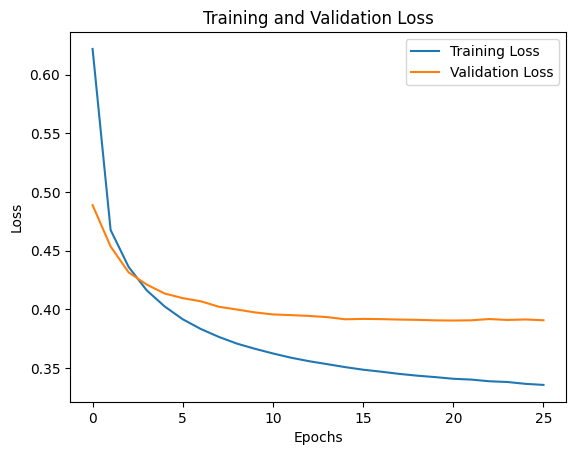

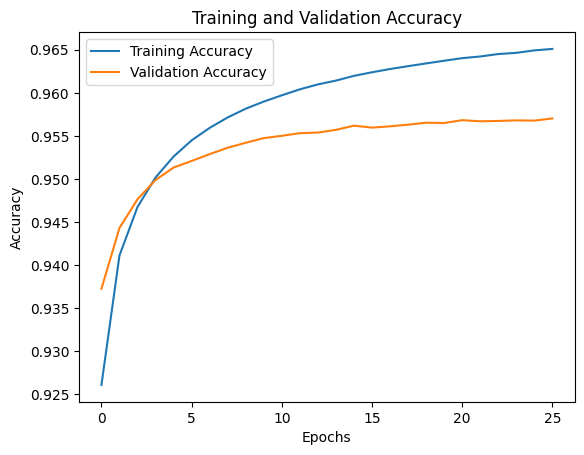

In [12]:
#############################################################################
# 5. Prepare training data
decoder_input_data = target_sequences[:, :-1]  # Remove last token
decoder_target_data = target_sequences[:, 1:]  # Remove first token
decoder_target_data = np.expand_dims(decoder_target_data, -1)  # Expand dims for loss computation

print(f"Input Sequences Shape: {input_sequences.shape}")  # (num_samples, max_encoder_seq_length)
print(f"Decoder Input Data Shape: {decoder_input_data.shape}")  # (num_samples, max_decoder_seq_length - 1)
print(f"Decoder Target Data Shape: {decoder_target_data.shape}")  # (num_samples, max_decoder_seq_length - 1, 1)

# 6. Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Train model
batch_size = 64
epochs = 50

history = model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stopping]
)

# 8. Plot training progress
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [13]:
# prompt: also save the tokenizers

import pickle

# ... (your existing code) ...

model_path = "/content/drive/MyDrive/NLP/110k_spa_eng.keras"  # Choose a suitable path
model.save(model_path)
print(f"Model saved to: {model_path}")

# Save the weights
weights_path = "/content/drive/MyDrive/NLP/110k_spa_eng.weights.h5"
model.save_weights(weights_path)
print(f"Weights saved to: {weights_path}")

# Save tokenizers
with open('/content/drive/MyDrive/NLP/110k_tokenizer_es.pickle', 'wb') as handle:
    pickle.dump(tokenizer_es, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/NLP/110k_tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizers saved to Google Drive.")

Model saved to: /content/drive/MyDrive/NLP/110k_spa_eng.keras
Weights saved to: /content/drive/MyDrive/NLP/110k_spa_eng.weights.h5
Tokenizers saved to Google Drive.


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model
decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single")

# Reuse the embedding layer for inference
decoder_embedding_layer = Embedding(
    input_dim=target_vocab_size,
    output_dim=embedding_dim,
    weights=[decoder_embedding_matrix],
    trainable=True,
    name="decoder_embedding_inference"
)

decoder_embedding_single = decoder_embedding_layer(decoder_inputs_single)

decoder_state_input_h = Input(shape=(512,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(512,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_single, initial_state=decoder_states_inputs
)

# Attention mechanism
context_vector = compute_attention(encoder_outputs, decoder_lstm_outputs)
decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_outputs, context_vector])
decoder_outputs = decoder_dense(decoder_combined_context)

# Final decoder inference model
decoder_model = Model(
    [decoder_inputs_single, encoder_outputs] + decoder_states_inputs,
    [decoder_outputs, state_h, state_c]
)

# Function to decode a sequence
def decode_sequence(input_seq):
    # Encode the input sequence
    encoder_out, state_h, state_c = encoder_model.predict(input_seq)

    # Initialize decoder inputs with start token
    start_token = tokenizer_en.word_index.get('\t', 0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # Predict the next word
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_out, state_h, state_c])

        # Sample the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_en.index_word.get(sampled_token_index, '<unk>')

        # Stop if end token is reached or sentence length exceeds limit
        if sampled_word == '\n' or len(decoded_sentence.split()) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + " "

        # Update the target sequence and states
        target_seq[0, 0] = sampled_token_index
        state_h, state_c = h, c

    return decoded_sentence.strip()

# Prepare test data
test_input_sequences = tokenizer_es.texts_to_sequences(input_texts[90000:])
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_encoder_seq_length, padding='post')

test_target_texts = target_texts[90000:]  # Ground truth for comparison

# Evaluate translations
for i in range(5):  # Test on the first 5 samples
    test_input_seq = test_input_sequences[i:i+1]  # Take one input sequence at a time
    predicted_sentence = decode_sequence(test_input_seq)

    print(f"Input Sentence (Spanish): {input_texts[90000 + i]}")
    print(f"Predicted Translation (English): {predicted_sentence}")
    print(f"Actual Translation (English): {test_target_texts[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input Sentence (Spanish): Eso no puede ser correcto.
Predicted Translation (English): that can't not right.
Actual Translation (English):  	 That can't be right. 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input Sentence (Spanish): Necesito saber algo.
Predicted Translation (English): i need to to to
Actual Translation (English):  	 I need to know something. 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [15]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def decode_batch(input_seqs):
    # Encode the input sequences
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seqs, batch_size=64)

    # Prepare the start token for all sequences in the batch
    batch_size = input_seqs.shape[0]
    start_token = tokenizer_en.word_index.get('\t', 0)
    target_seqs = np.zeros((batch_size, 1))
    target_seqs[:, 0] = start_token

    # Initialize variables
    stop_conditions = [False] * batch_size
    decoded_sentences = [''] * batch_size
    max_steps = max_decoder_seq_length

    # Decode the batch
    for _ in range(max_steps):
        # Predict next tokens
        output_tokens, h, c = decoder_model.predict(
            [target_seqs, encoder_outputs, state_h, state_c], batch_size=64
        )

        # Sample the most probable tokens
        sampled_token_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Append the words to the sentences
        for i, token_index in enumerate(sampled_token_indices):
            if not stop_conditions[i]:
                sampled_word = tokenizer_en.index_word.get(token_index, '<unk>')
                if sampled_word == '\n' or len(decoded_sentences[i].split()) > max_decoder_seq_length:
                    stop_conditions[i] = True
                else:
                    decoded_sentences[i] += sampled_word + ' '

        # Update the target sequences for the next step
        target_seqs[:, 0] = sampled_token_indices

        # Update the states
        state_h, state_c = h, c

        # Break if all sentences are done
        if all(stop_conditions):
            break

    return [sentence.strip() for sentence in decoded_sentences]

def compute_bleu_scores(predicted_sentences, reference_sentences):
    smooth_fn = SmoothingFunction().method1
    bleu_scores = []
    for predicted, reference in zip(predicted_sentences, reference_sentences):
        reference_tokens = [reference.strip().split()]
        predicted_tokens = predicted.strip().split()
        score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smooth_fn)
        bleu_scores.append(score)
    return bleu_scores

input_texts, target_texts = preprocess_data(pairs[110000:],num_samples=30000)

# Tokenize and pad the test data
test_input_sequences = tokenizer_es.texts_to_sequences(input_texts[:])
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_encoder_seq_length, padding='post')

test_target_sequences = tokenizer_en.texts_to_sequences(target_texts[:])
test_target_sentences = target_texts[:]  # Keep raw target sentences for reference

# Decode the test set in batches
batch_size = 64
decoded_sentences = []
for i in tqdm(range(0, len(test_input_sequences), batch_size)):
    batch_input_seqs = test_input_sequences[i:i+batch_size]
    decoded_batch = decode_batch(batch_input_seqs)
    decoded_sentences.extend(decoded_batch)

# Compute BLEU scores for all decoded sentences
bleu_scores = compute_bleu_scores(decoded_sentences, test_target_sentences)
average_bleu = np.mean(bleu_scores)

print(f"Average BLEU Score on Test Data [110000:140000]: {average_bleu:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Preprocess data for Spanish to English testing
def preprocess_data(pairs, num_samples=None):
    input_texts, target_texts = [], []
    for input_text, target_text in pairs[80000:num_samples]:
        # Add spaces around \t and \n to ensure they are treated as separate tokens
        target_text = " \t " + target_text.strip() + " \n "
        input_texts.append(input_text.strip())  # Spanish input (strip whitespace)
        target_texts.append(target_text)       # English target
    return input_texts, target_texts

# Prepare Spanish-to-English test data
test_input_texts, test_target_texts = preprocess_data(pairs, num_samples=90000)

# Convert to sequences
test_input_sequences = tokenizer_es.texts_to_sequences(test_input_texts)  # Spanish input
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_encoder_seq_length, padding='post')

test_target_sequences = tokenizer_en.texts_to_sequences(test_target_texts)  # English target
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_decoder_seq_length, padding='post')

# Prepare decoder input and target data
test_decoder_input_data = test_target_sequences[:, :-1]  # Remove last token
test_decoder_target_data = test_target_sequences[:, 1:]  # Remove first token
test_decoder_target_data = np.expand_dims(test_decoder_target_data, -1)  # Expand dims for loss computation

# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    [test_input_sequences, test_decoder_input_data],
    test_decoder_target_data,
    batch_size=64
)

print(f"Test Loss (Spanish to English): {test_loss}")
print(f"Test Accuracy (Spanish to English): {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9647 - loss: 0.3375
Test Loss (Spanish to English): 0.34507232904434204
Test Accuracy (Spanish to English): 0.9635195136070251


In [17]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=be40a26228cf1c7f5d986a2af0582fd59edf281569b4ac041916bae0fe9c24db
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [18]:
from rouge_score import rouge_scorer

def compute_rouge_scores(predicted_sentences, reference_sentences):
    # Initialize the ROUGE scorer with ROUGE-1 and ROUGE-L metrics
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    rouge_scores = []

    # Iterate over the predicted and reference sentences
    for predicted, reference in zip(predicted_sentences, reference_sentences):
        scores = scorer.score(reference, predicted)
        rouge_scores.append(scores)

    return rouge_scores

# Example usage (assuming you have predicted_sentences and test_target_sentences)
# predicted_sentences: List of generated sentences by your model
# test_target_sentences: List of ground truth/reference sentences

rouge_scores = compute_rouge_scores(decoded_sentences, test_target_sentences)

# Calculate average ROUGE scores (F-measure)
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

# Average ROUGE-1 and ROUGE-L F-measures
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if len(rouge1_scores) > 0 else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if len(rougeL_scores) > 0 else 0

# Print the average ROUGE scores
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")


Average ROUGE-1 Score: 0.4107
Average ROUGE-L Score: 0.4040
